total number of images for car: 1000


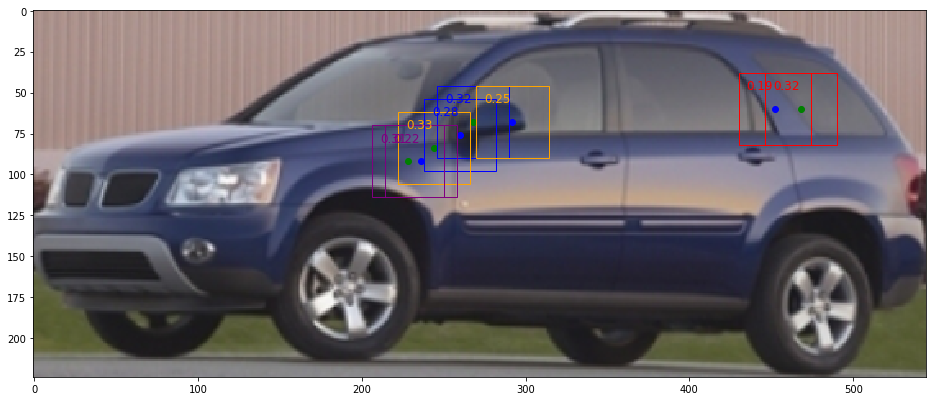

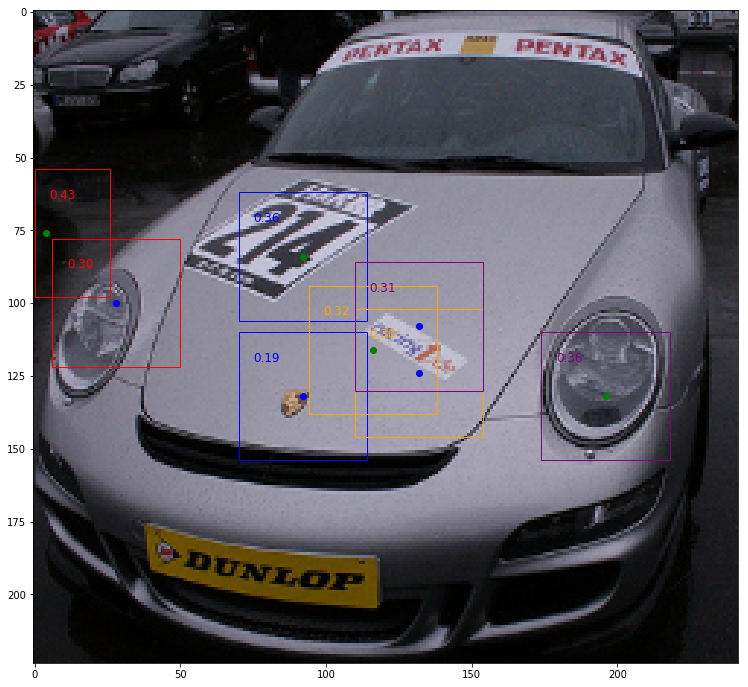

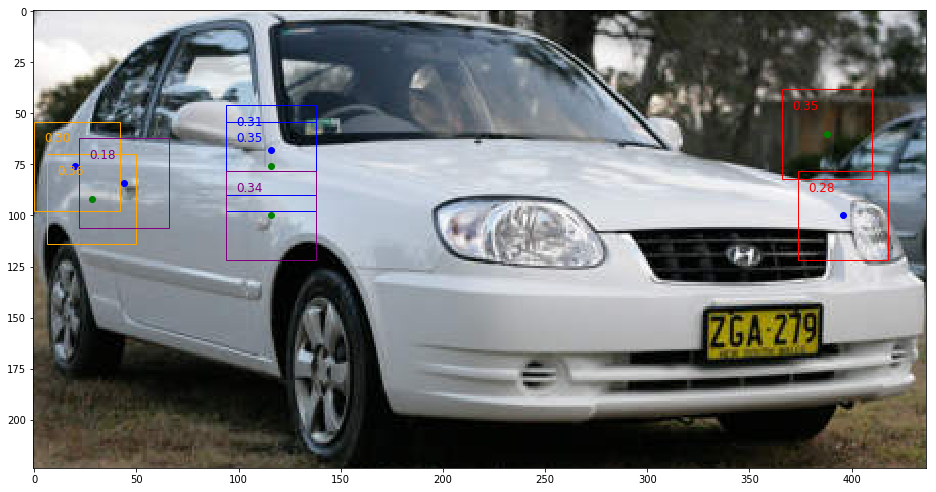

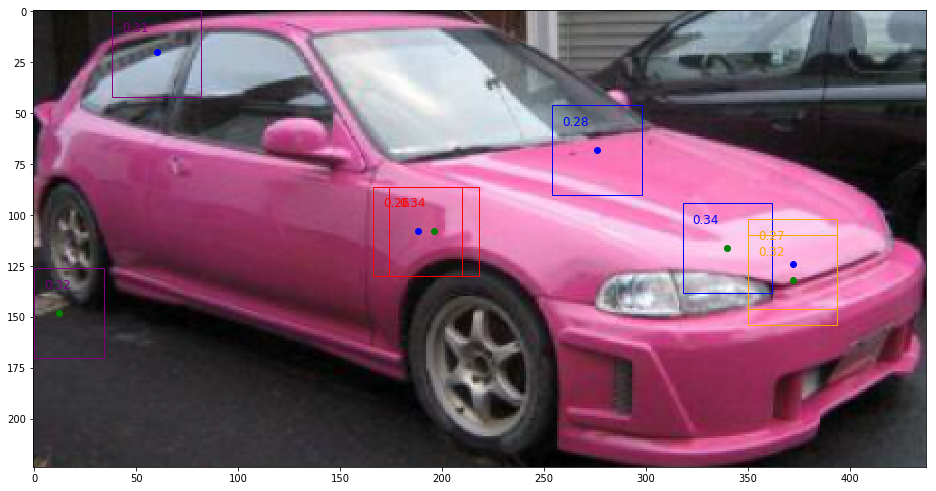

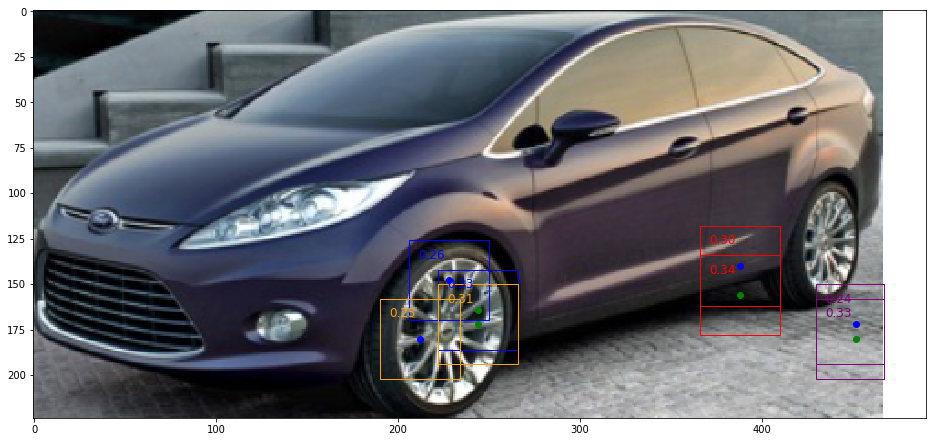

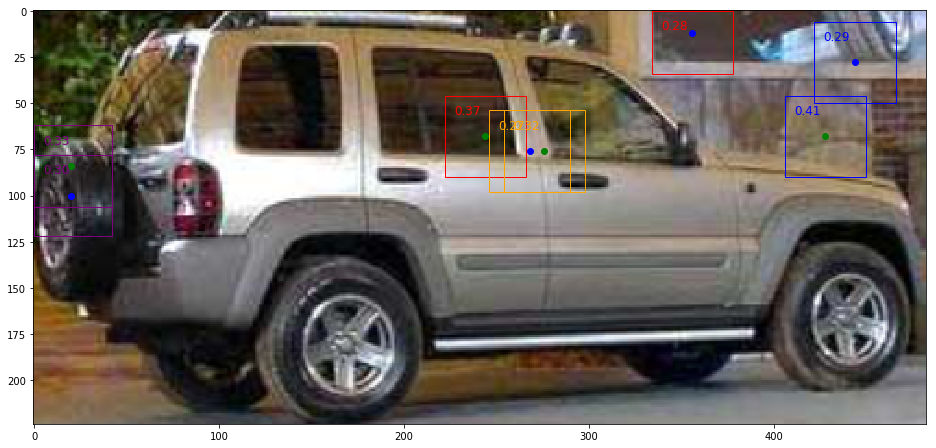

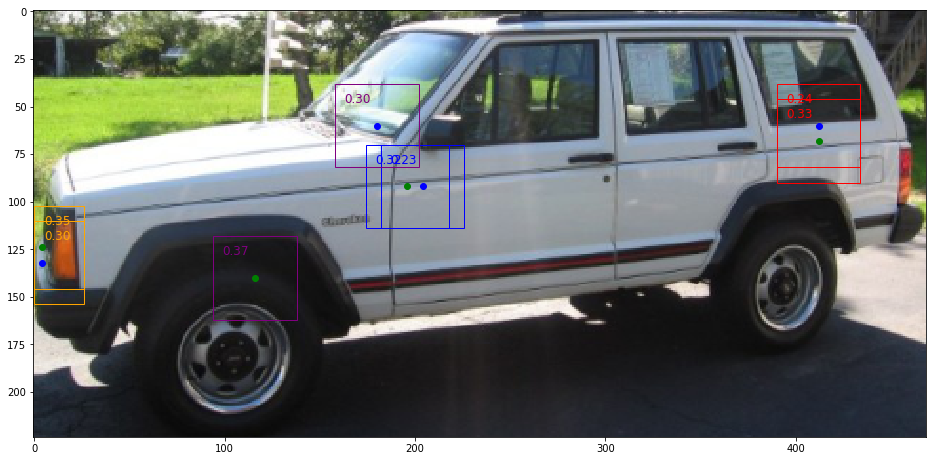

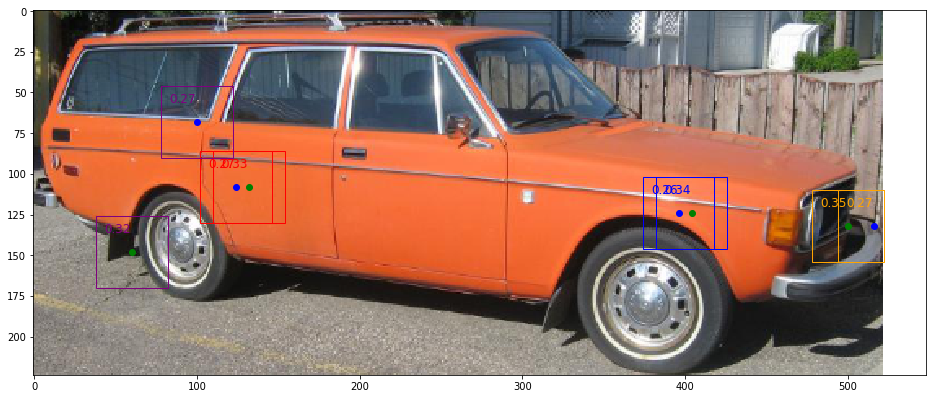

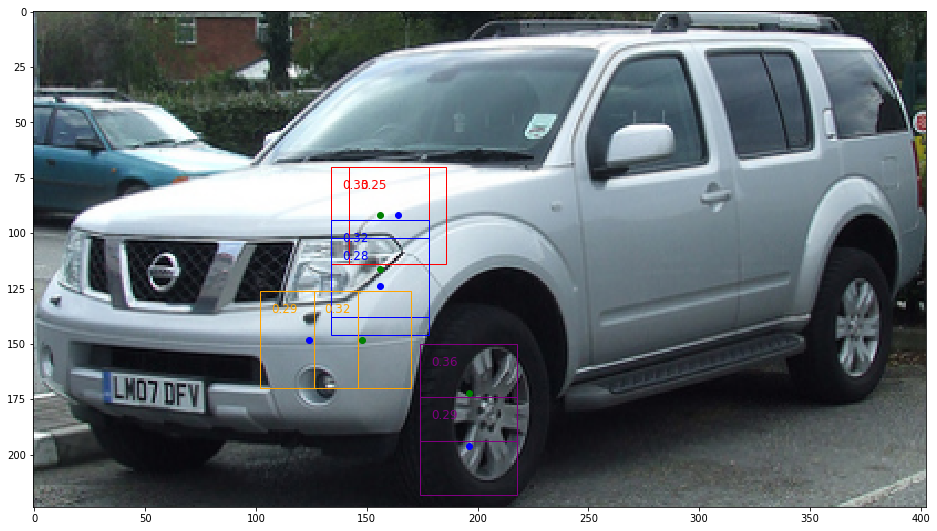

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [50]:
import numpy as np
import math
import pickle
from scipy.spatial.distance import cdist
import scipy.io as sio
from FeatureExtractor import *
from config_voting import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

set_type='train'
category='car'
dir_img = Dataset['img_dir'].format(category)
dir_anno = Dataset['anno_dir'].format(category)

file_list = Dataset['{0}_list'.format(set_type)].format(category)
assert(os.path.isfile(file_list))

with open(file_list, 'r') as fh:
    content = fh.readlines()

img_list = [x.strip().split() for x in content]
img_num = len(img_list)
print('total number of images for {1}: {0}'.format(img_num, category))

file_cache_feat = os.path.join(Feat['cache_dir'], '{0}_{1}_{2}_car_pool3.pickle'.format(category, dataset_suffix, set_type))
assert(os.path.isfile(file_cache_feat))
with open(file_cache_feat, 'rb') as fh:
    layer_feature, _ = pickle.load(fh)
    

dict_file='/export/home/qliu24/qing_voting_139/qing_voting_py/data/dictionary_PASCAL3D+_car_VGG16_pool3_K200_vMFMM30.pickle'
with open(dict_file, 'rb') as fh:
    _, centers, _ = pickle.load(fh)

layer_feature_dist = []
for nn in range(len(layer_feature)):
    iheight,iwidth = layer_feature[nn].shape[0:2]
    lff = layer_feature[nn].reshape(-1, 256)
    lff_norm = lff/np.sqrt(np.sum(lff**2, 1)).reshape(-1,1)
    layer_feature_dist.append(cdist(lff_norm, centers, 'cosine').reshape(iheight,iwidth,-1))    


magic_thh = 0.31
color_ls = ['red','blue','orange','purple']
for nn in [99,199,299,399,499,599,699,799,899,999]:
# for nn in [99]:
    file_img = os.path.join(dir_img, '{0}.JPEG'.format(img_list[nn][0]))
    assert(os.path.isfile(file_img))
    img = cv2.imread(file_img)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.show()

    height, width = img.shape[0:2]

    file_anno = os.path.join(dir_anno, '{0}.mat'.format(img_list[nn][0]))
    assert(os.path.isfile(file_anno))
    mat_contents = sio.loadmat(file_anno)
    record = mat_contents['record']
    objects = record['objects']
    bbox = objects[0,0]['bbox'][0,int(img_list[nn][1])-1][0]
    bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
            min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]
    patch = img[bbox[1]-1: bbox[3], bbox[0]-1: bbox[2], :]
    # patch = cv2.resize(patch, (scale_size, scale_size))
    patch = myresize(patch, scale_size, 'short')
    phight, pwidth = patch.shape[0:2]
    
    lfb = (layer_feature_dist[nn]<magic_thh).astype(int)
    irow, icol = np.where(np.sum(lfb, axis=2)==0)
    
    fig,ax = plt.subplots(1, figsize=(16, 12))
    ax.imshow(patch[...,::-1])
    iistart = int(len(irow)/2)
    
    color_i = 0
    for rr, cc in zip(irow[[iistart-15, iistart, iistart+15, iistart+30]], icol[[iistart-15, iistart, iistart+15, iistart+30]]):
        hi = Astride * rr - Apad+Arf/2
        wi = Astride * cc - Apad+Arf/2
        bbi = [max(int(wi-Arf/2), 0), max(int(hi-Arf/2), 0), min(int(wi+Arf/2), pwidth), min(int(hi+Arf/2), phight)]
        rect = patches.Rectangle((bbi[0],bbi[1]), bbi[2]-bbi[0], bbi[3]-bbi[1],\
                             linewidth=1,edgecolor=color_ls[color_i],facecolor='none')
        ax.add_patch(rect)
        ax.scatter(wi, hi, color='green')
        close_dis = np.min(layer_feature_dist[nn][rr,cc])
        ax.text(bbi[0]+5,bbi[1]+10, '{:.2f}'.format(close_dis), fontsize = '12', color = color_ls[color_i])
        
        
        close_vci = np.argmin(layer_feature_dist[nn][rr,cc])
        rr2, cc2 = np.where(lfb[:,:,close_vci]==1)
        minidx2 = np.argmin(cdist(np.array([[rr,cc]]), np.array([pp2 for pp2 in zip(rr2,cc2)])))
        
        rmin, cmin = np.array([pp2 for pp2 in zip(rr2,cc2)])[minidx2]
        # close_dis = np.min(layer_feature_dist[nn][rr,cc])
        # print(close_dis)
        # vci_example_dis = np.min(layer_feature_dist[nn][:,:,close_vci])
        # rmin, cmin = np.where(layer_feature_dist[nn][:,:,close_vci]==vci_example_dis)
        hi = Astride * rmin - Apad + Arf/2
        wi = Astride * cmin - Apad + Arf/2
        bbi = [max(int(wi-Arf/2), 0), max(int(hi-Arf/2), 0), min(int(wi+Arf/2), pwidth), min(int(hi+Arf/2), phight)]
        rect = patches.Rectangle((bbi[0],bbi[1]), bbi[2]-bbi[0], bbi[3]-bbi[1],\
                             linewidth=1,edgecolor=color_ls[color_i],facecolor='none')
        ax.add_patch(rect)
        ax.scatter(wi, hi, color='blue')
        vci_example_dis = layer_feature_dist[nn][rmin, cmin, close_vci]
        ax.text(bbi[0]+5,bbi[1]+10, '{:.2f}'.format(vci_example_dis), fontsize = '12', color = color_ls[color_i])
        
        color_i += 1
        '''
        patch1 = patch[max(int(hi-Arf/2), 0):min(int(hi+Arf/2), phight), max(int(wi-Arf/2), 0):min(int(wi+Arf/2), pwidth)]
        plt.imshow(patch1[...,::-1])
        plt.show()
        hi2 = Astride * rmin - Apad + Arf/2
        wi2 = Astride * cmin - Apad + Arf/2
        patch2 = patch[max(int(hi2-Arf/2), 0):min(int(hi2+Arf/2), phight), max(int(wi2-Arf/2), 0):min(int(wi2+Arf/2), pwidth)]
        plt.imshow(patch2[...,::-1])
        '''
        
    plt.savefig('pool3_empty_examples/{0}_vMFMM30_closefire.png'.format(nn), bbox_inches='tight')
    # plt.show()
        

In [36]:
rr,cc

(8, 33)

In [3]:
import numpy as np
arr = np.array([[[0,1],[2,3]],[[4,5],[6,7]]])
print(arr)
np.argmin(arr, axis=0)

[[[0 1]
  [2 3]]

 [[4 5]
  [6 7]]]


array([[0, 0],
       [0, 0]])